In [1]:
#!pip install --upgrade gym
#!pip install --upgrade gym-notices

In [27]:
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
torch.manual_seed(0)

import base64, io

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob

device = torch.device("mps" if torch.backends.mps.is_available() else
                      "cuda:0" if torch.cuda.is_available() else
                      "cpu")
device

env = gym.make('CartPole-v0')
#env.seed(0)

### Define Policy
Unlike value-based method, the output of policy-based method is the probability of each action. It can be represented as policy. So activation function of output layer will be softmax, not ReLU.

In [28]:
class Actor(nn.Module):
    def __init__(self, state_size=4, action_size=2, hidden_size=32):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = self.fc2(x)
        # we just consider 1 dimensional probability of action
        return F.softmax(x, dim=1)

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        model = Categorical(probs)
        action = model.sample()
        return action.item(), model.log_prob(action)

In [29]:
class Critic(nn.Module):
    def __init__(self, state_size=4, action_size=2, hidden_size=32):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(state_size + action_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, state):
        x = torch.cat([state, action], dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        # we just consider 1 dimensional probability of action
        return x

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        model = Categorical(probs)
        action = model.sample()
        return action.item(), model.log_prob(action)

### SAC

In [30]:
def sac(policy, optimizer, early_stop, n_episode):
    state_old = env.reset()
    buffer = []
    action, _ = policy.act(state_old)
    state, reward, done, _ = env.step(action)
    buffer.append({"s" : state_old,
                   "a" : action,
                   "r" : reward,
                   "sprime" : state,
                   "done" : done})

    if done:
        env.reset()

In [39]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gym

# Define the actor network
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        return x

# Define the critic network
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)

    def forward(self, state, action):
        #print(len(np.shape(action)))
        #if len(np.shape(action)) == 1:
        #    action = torch.FloatTensor(action).unsqueeze(1) # désolé pour ça
       #print("action", action)
        x = torch.cat([state.squeeze(), action], dim=1)
        #print(np.shape(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        #print("survived")
        return x

# Define the soft Q-function network
class SoftQNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(SoftQNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define the Soft Actor-Critic agent
class SACAgent:
    def __init__(self, state_dim, action_dim, hidden_dim=256, lr=3e-4):
        self.actor = Actor(state_dim, action_dim, hidden_dim)
        self.critic1 = Critic(state_dim, action_dim, hidden_dim)
        self.critic2 = Critic(state_dim, action_dim, hidden_dim)
        self.target_critic1 = Critic(state_dim, action_dim, hidden_dim)
        self.target_critic2 = Critic(state_dim, action_dim, hidden_dim)
        self.soft_q_network = SoftQNetwork(state_dim, action_dim, hidden_dim)

        self.target_critic1.load_state_dict(self.critic1.state_dict())
        self.target_critic2.load_state_dict(self.critic2.state_dict())

        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr)
        self.critic1_optimizer = optim.Adam(self.critic1.parameters(), lr=lr)
        self.critic2_optimizer = optim.Adam(self.critic2.parameters(), lr=lr)
        self.soft_q_network_optimizer = optim.Adam(self.soft_q_network.parameters(), lr=lr)

    def select_action(self, state):
        #print(state)
        #state = torch.FloatTensor(state[0]).unsqueeze(0)
        with torch.no_grad():
            action = self.actor(state)
        #print(action)
        #print(action)
        #print(action.cpu()[0])
        #print(action.detach().numpy())
        #action_probs = F.softmax(action.detach().numpy())  # Sample from softmax (discrete) or Gaussian (continuous)
        action_probs = action.exp().detach().numpy()
        #print(np.argmax(action_probs))
        return action_probs
    
    def train(self, replay_buffer, batch_size=128, gamma=0.99, alpha=0.2):
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = replay_buffer.sample(batch_size)
        #print("batch",action_batch)
        state_batch = torch.FloatTensor(state_batch)
        action_batch = torch.FloatTensor(action_batch)
        reward_batch = torch.FloatTensor(reward_batch).unsqueeze(1)
        next_state_batch = torch.FloatTensor(next_state_batch)
        done_batch = torch.FloatTensor(np.float32(done_batch)).unsqueeze(1)

        # Update Q-networks
        with torch.no_grad():
            next_actions = self.actor(next_state_batch)
            next_actions_prob = next_actions
            #next_actions_prob = torch.FloatTensor(next_actions.exp().detach().numpy())
            #print("next", np.argmax(next_actions_prob, dim=1))
            next_q_values1 = self.target_critic1(next_state_batch, next_actions_prob)
            next_q_values2 = self.target_critic2(next_state_batch, next_actions_prob)
            #print(np.shape(torch.argmax(torch.log(self.actor(next_state_batch)))))
            next_q_values = torch.min(next_q_values1, next_q_values2) - alpha * torch.log(torch.argmax(self.actor(next_state_batch)))

            expected_q_values = reward_batch + gamma * (1 - done_batch) * next_q_values
            #print(np.shape(next_q_values1),np.shape(next_q_values2),np.shape(next_q_values))
        #print("torchtensor",action_batch)
        q1 = self.critic1(state_batch, action_batch)
        q2 = self.critic2(state_batch, action_batch)

        #print(np.shape(q1),np.shape(expected_q_values))
        #print(q1)
        critic1_loss = F.mse_loss(q1, expected_q_values)
        critic2_loss = F.mse_loss(q2, expected_q_values)

        self.critic1_optimizer.zero_grad()
        critic1_loss.backward()
        self.critic1_optimizer.step()

        self.critic2_optimizer.zero_grad()
        critic2_loss.backward()
        self.critic2_optimizer.step()

        # Update actor
        actions = self.actor(state_batch)
        actor_loss = (alpha * torch.log(actions) - self.soft_q_network(state_batch, actions)).mean()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Update target networks
        for target_param, param in zip(self.target_critic1.parameters(), self.critic1.parameters()):
            target_param.data.copy_(0.995 * target_param.data + 0.005 * param.data)

        for target_param, param in zip(self.target_critic2.parameters(), self.critic2.parameters()):
            target_param.data.copy_(0.995 * target_param.data + 0.005 * param.data)

# Initialize environment
env = gym.make('CartPole-v0')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0] if isinstance(env.action_space, gym.spaces.Box) else env.action_space.n
# Initialize agent
agent = SACAgent(state_dim, action_dim)

# Initialize replay buffer
class ReplayBuffer:
    def __init__(self, max_size=1e6):
        self.storage = []
        self.max_size = max_size
        self.ptr = 0

    def add(self, transition):
        #print(transition[0])
        if len(self.storage) == self.max_size:
            self.storage[int(self.ptr)] = transition
            self.ptr = (self.ptr + 1) % self.max_size
        else:
            self.ptr += 1
            self.storage.append(transition)

    def sample(self, batch_size):
        ind = np.random.randint(0, self.ptr, size=batch_size)
        #print(len(self.storage),self.ptr,ind)
        states, actions, rewards, next_states, dones = [], [], [], [], []
        for i in ind:
            s, a, r, s_, d = self.storage[i]
            states.append(np.array(s, copy=False))
            actions.append(np.array(a, copy=False))
            rewards.append(np.array(r, copy=False))
            next_states.append(np.array(s_, copy=False))
            dones.append(np.array(d, copy=False))

        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones)

# Training loop
torch.device("cpu")
n_episodes = 1000
replay_buffer = ReplayBuffer()
rewards = []
progress_bar = tqdm(total=n_episodes)

for _ in range(n_episodes):  # Run for 1000 episodes
    state = env.reset()
    state = torch.FloatTensor(state[0])#.unsqueeze(0)
    episode_reward = 0
    done = False
    while not done:
        action = agent.select_action(state)
        #print(action)
        next_state, reward, done, _, _ = env.step(np.argmax(action))
        replay_buffer.add((state, action, reward, next_state, done))
        episode_reward += reward
        state = torch.FloatTensor(next_state)#.unsqueeze(0)

        if len(replay_buffer.storage) > 128:
            agent.train(replay_buffer)
    progress_bar.update(1)
    rewards.append(episode_reward)
    #print("Episode Reward:", episode_reward)

env.close()


/Users/alan/Library/Python/3.9/lib/python/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
100%|██████████| 1000/1000 [01:20<00:00, 12.38it/s]
/Users/alan/Library/Python/3.9/lib/python/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


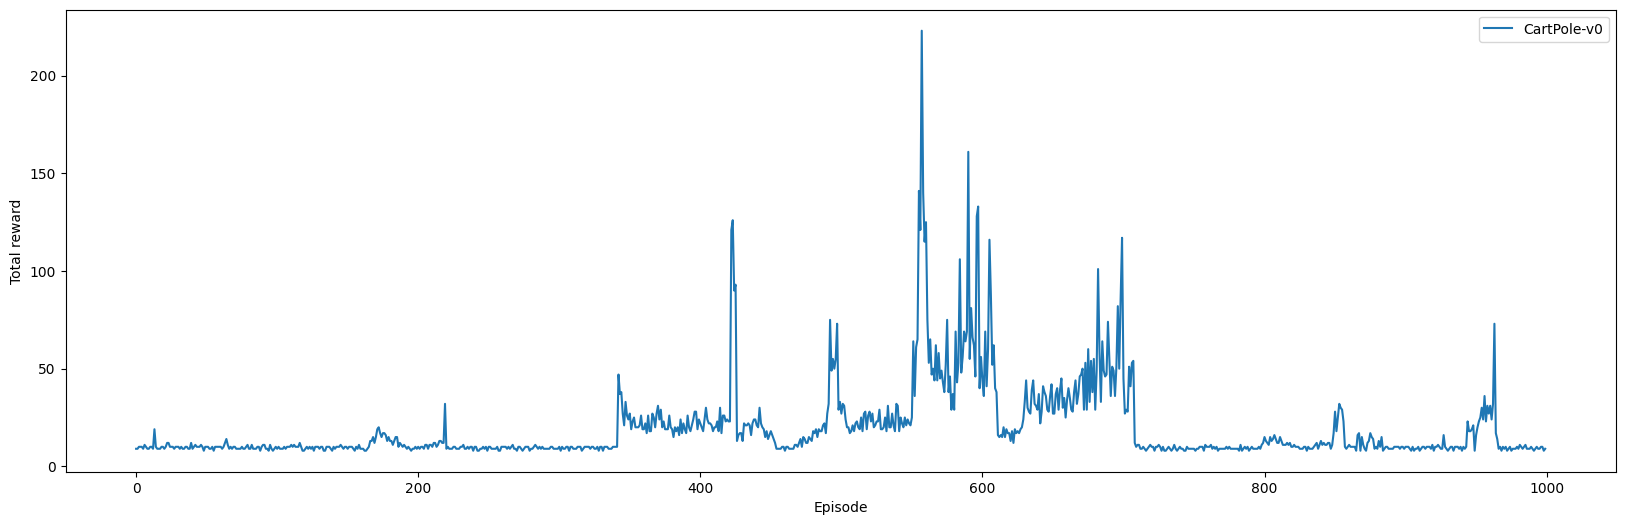

In [40]:
plt.figure(figsize=(20,6))
plt.plot(rewards,label="CartPole-v0")
plt.xlabel("Episode")
plt.ylabel("Total reward")
plt.legend()
plt.show()